
![HELP logo](https://github.com/pdh21/FIR_bootcamp_2016/blob/master/Figures/Help_Logo.png?raw=true)
# XID+
### _Peter Hurley_

This notebook provides some example code for basic analysis of the xid+ outputs, including:
1. Loading up output
2. Creating Posterior replicated maps and animations
3. Creating marginalised posterior plots
4. Creating Bayesian p-value maps

Import required modules

In [1]:
from astropy.io import ascii
import pylab as plt
%matplotlib inline

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d

import pystan
import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
output_folder='./'

Load up posterior output from XID+

In [2]:
priors,posterior=xidplus.load('test.pkl')

In order to compare how good our fit is, its often useful to look at original map. There is a routine within XID+ that makes the original fits map from the data stored within the prior class. Lets use that to make the SPIRE maps for the region we have fit.

Now lets use the [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/index.html) plotting package and [APLpy](http://aplpy.readthedocs.io/en/stable/) package to view those maps, plotting the sources we have fit on top of those maps.

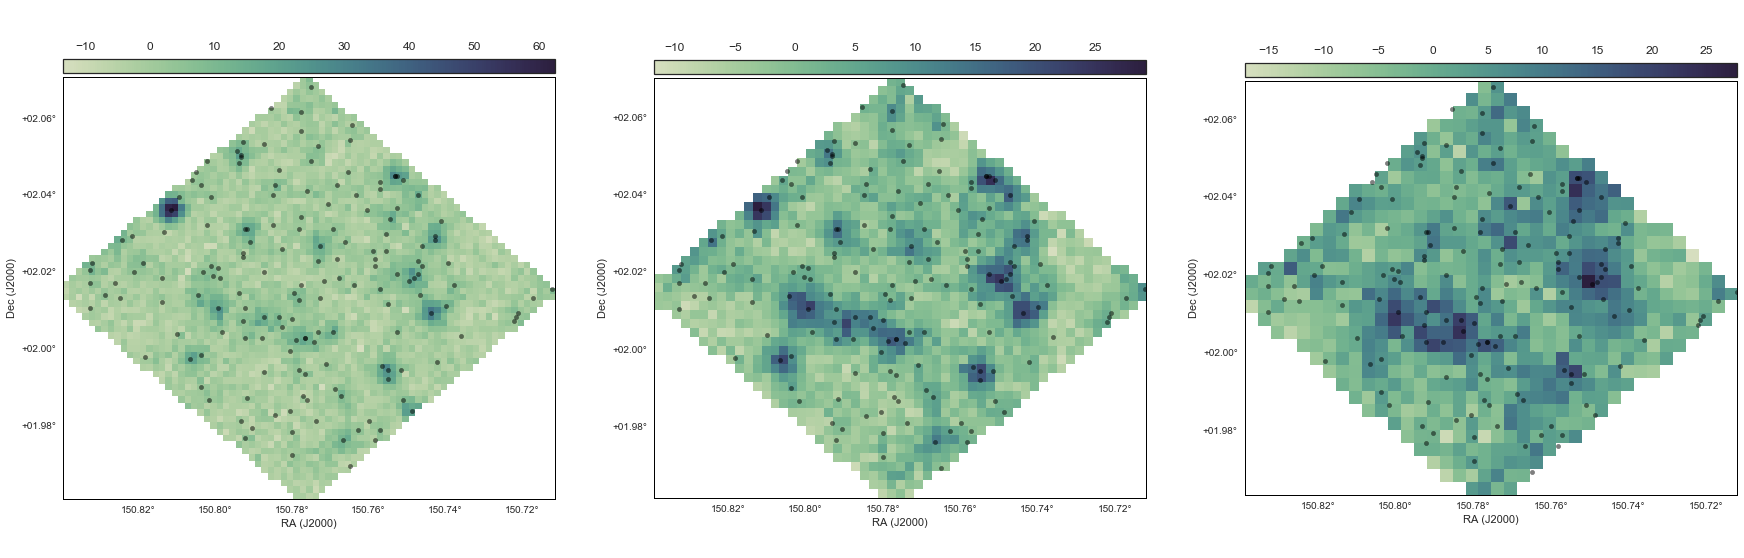

In [3]:
figs,fig=xidplus.plot_map(priors)

### Posterior replicated data

We can use each sample we have from the posterior, and use it to make a replicated map, including simulating the instrumental noise, and the estimated confusion noise. You can think of these maps as all the possible maps that are allowed by the data. 

In [7]:
xidplus.replicated_map_movie(priors,posterior,50)

In [29]:
#Select source you want to plot joint distribution
s1=14
s2=45

 We can see that sources 68 and 5 are close together, lets look at their joint posterior probabiity distribution. The code below plots the 1,2 and 3 sigma contours for the joint posterior, and an inset of the real map.

INFO:astropy:Auto-setting vmin to -1.570e+01
INFO:astropy:Auto-setting vmax to  4.011e+01


INFO: Auto-setting vmin to -1.570e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.011e+01 [aplpy.core]


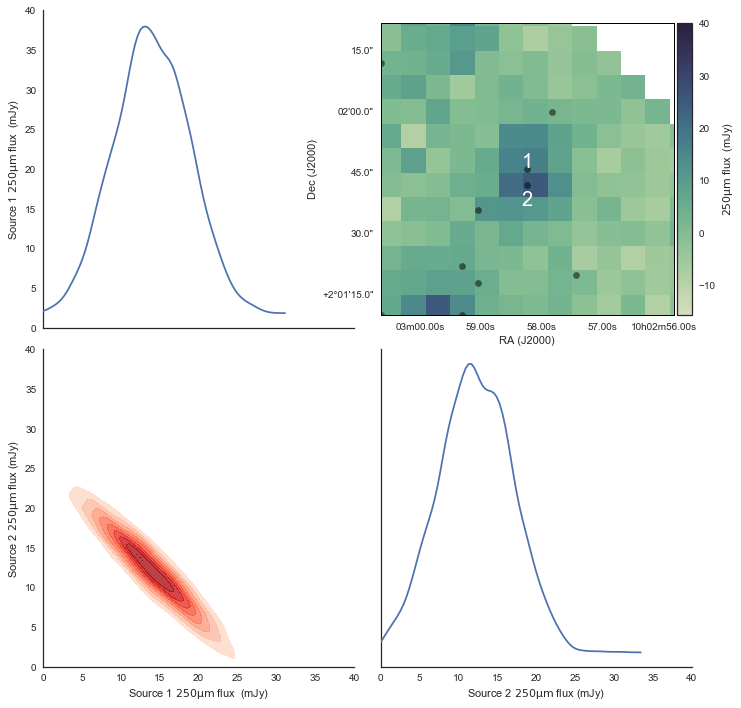

In [42]:
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
sns.set_style("white")


import scipy
# Make a 2d normed histogram
H,xedges,yedges=np.histogram2d(posterior.samples['src_f'][:,0,[s1]].reshape(-1),posterior.samples['src_f'][:,0,[s2]].reshape(-1),bins=20,normed=True)

norm=H.sum() # Find the norm of the sum
# Set contour levels
contour1=0.99
contour2=0.95
contour3=0.68

# Set target levels as percentage of norm
target1 = norm*contour1
target2 = norm*contour2
target3 = norm*contour3

# Take histogram bin membership as proportional to Likelihood
# This is true when data comes from a Markovian process
def objective(limit, target):
    w = np.where(H>limit)
    count = H[w]
    return count.sum() - target

# Find levels by summing histogram to objective
level1= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target1,))
level2= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target2,))
level3= scipy.optimize.bisect(objective, H.min(), H.max(), args=(target3,))

# For nice contour shading with seaborn, define top level
level4=H.max()
levels=[level1,level2,level3,level4]


labels=[r'Source 1 $250\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $250\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(posterior.samples['src_f'][:,0,[s1,s2]],columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.set(ylim=(0,40))
g.set(xlim=(0,40))

g.axes[0,1].spines['bottom'].set_color('white')
g.axes[0,1].spines['left'].set_color('white')
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

real_250 = aplpy.FITSFigure(postmaps.make_fits_image(priors[0],priors[0].sim)[1],figure=g.fig,subplot=(2,2,2))
real_250.show_colorscale(cmap=cmap)

real_250.show_markers(priors[0].sra, priors[0].sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_250.recenter(priors[0].sra[s1], priors[0].sdec[s1], radius=0.01)

real_250.add_label(priors[0].sra[s1], priors[0].sdec[s1]+0.0005, 1, relative=False,size=20,color='white')
real_250.add_label(priors[0].sra[s2], priors[0].sdec[s2]-0.0010, 2, relative=False,size=20,color='white')



real_250.add_colorbar(axis_label_text=r'$250\mathrm{\mu m}$ flux  (mJy)')  


## Bayesian P-value maps

When examining goodness of fits, the typical method is to look at the residuals. i.e. $\frac{data - model}{\sigma}$. Because we have distribution of $y^{rep}$, we can do this in a more probabilisitic way. 

For one pixel, we can look at where the real flux in the map is in comparison to the distribution from $y^{rep}$

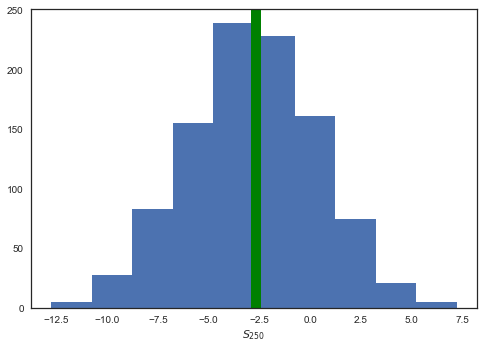

In [10]:
from xidplus import posterior_maps as postmaps

rep_maps=postmaps.replicated_maps(priors,posterior)
plt.hist(rep_maps[0][20,:])
plt.axvline(priors[0].sim[20],color='g',linewidth=10)
plt.xlabel(r'$S_{250}$')

We can calculate fraction of $y^{rep}$ samples above and below real map value. This is often referred to as the Bayesian p-value and is telling us the probability of drawing the real pixel value, from our model which has been inferred on the data. This is basically telling us if the model is missing something.

$\approx 0.5$ means nothing going on

0.99 or 0.01 means model is missing something. We can convert this to a typical '$\sigma$' level and create map versions of these Bayesian p-values:

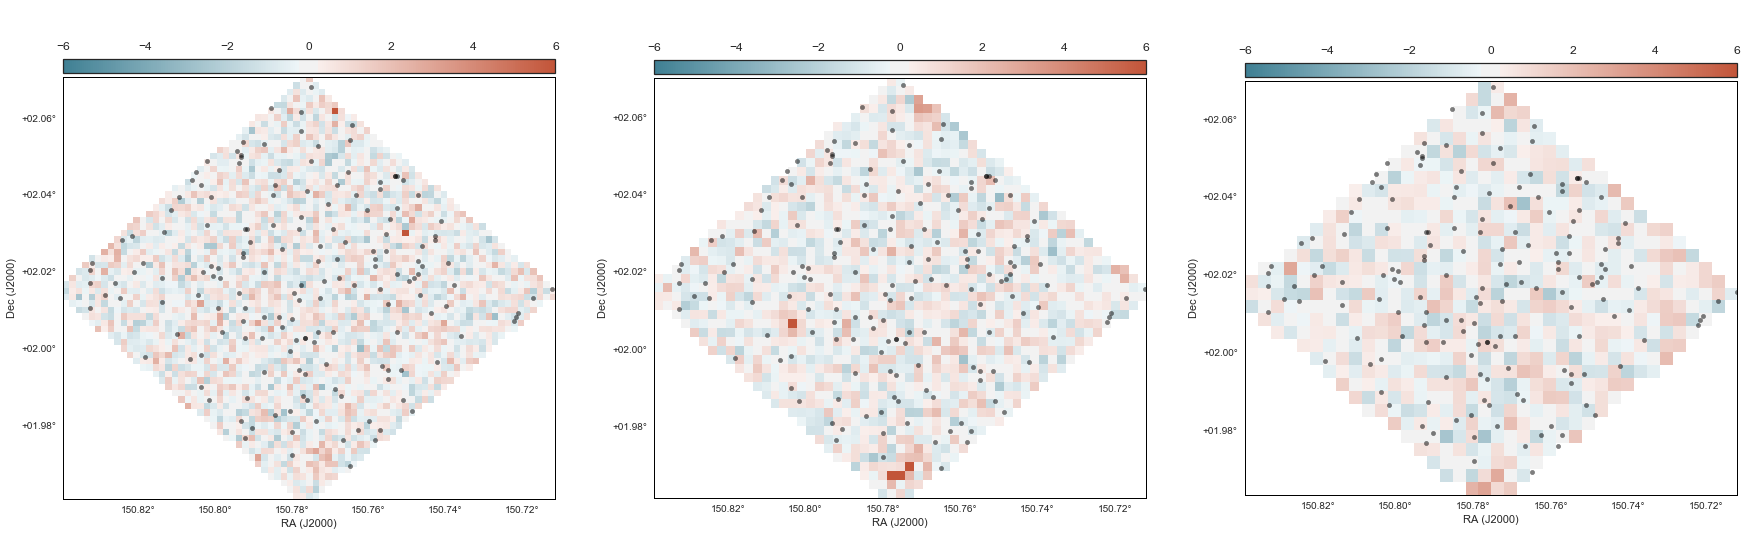

In [11]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

Red indicates the flux value in the real map is higher than our model thinks is possible. This could be indicating there is a source there that is not in our model.
Blue indicates the flux in the real map is lower than in our model. This is either indicating a very low density region or that too much flux has been assigned to one of the sources.

In [13]:
postmaps.Bayes_Pval_res(priors[0],rep_maps[0])

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.064,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.005,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.004,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.031,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
      

In [32]:
def Bayes_Pval_res(prior,post_rep_map):
    """
    
    :param prior: 
    :param post_rep_map: 
    :return: 
    """
    Bayes_pval_res_vals=np.empty((prior.nsrc))
    for i in range(0,prior.nsrc):
        ind= prior.amat_col == i

        T_data=np.sum((((prior.sim[prior.amat_row[ind]]-np.median(post_rep_map[prior.amat_row[ind],:],axis=1))/prior.snim[prior.amat_row[ind]])**2))
        T_rep=np.sum((((post_rep_map[prior.amat_row[ind],:]-np.median(post_rep_map[prior.amat_row[ind],:],axis=1)[:,None])/np.std(post_rep_map[prior.amat_row[ind],:],axis=1)[:,None])**2),axis=0)
        ind_T=T_data > 2*T_rep
        Bayes_pval_res_vals[i]=sum(ind_T)/np.float(post_rep_map.shape[1])
    return Bayes_pval_res_vals

In [33]:
Bayes_Pval_res(priors[0],rep_maps[0])

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.064,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.005,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.004,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.031,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
      